In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import joblib

# Mis utilitarios
from utils import *


# Set Path

In [2]:
el_path_main = Path(os.getcwd()).parent
el_path_main

WindowsPath('e:/backup Asus G15 27_10_2021/Colegio de Mates Bourbaki/DLA2501 - Deep Learning Avanzado/Flood forecasting')

# Load Datasets

## Gridded Time Series Dataset

In [3]:
df_gts = pd.read_csv(el_path_main / '2. Datos/Main gridded data/consol_df_peru.csv')
df_gts.columns = [x.lower() for x in df_gts]

In [4]:
variables_gridded = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet'] # incluimos WET para que incluye la componente de proceos autoreg

In [5]:
df_gts.sample(3)

,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,codmes,cuadrante_v1,cuadrante_v2,cuadrante_v3,mi_y,el_th_usado
1324500,-73.75,-0.25,86.200005,9.8,NaN,2.4,301.80002,20.7,25.600000,30.500000,29.300001,25.0,201006,1.00,1,1,1,25.0
712485,-69.25,-3.25,82.500000,8.8,NaN,2.8,233.40001,21.9,26.300001,30.700000,29.900000,21.0,195911,1.00,1,1,0,NaN
1355943,-74.25,-14.75,74.900000,11.2,6.0,2.9,157.30000,4.2,9.800000,15.400001,8.700000,23.0,201302,0.33,1,1,0,NaN


In [6]:
df_gts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499904 entries, 0 to 1499903
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   lon           1499904 non-null  float64
 1   lat           1499904 non-null  float64
 2   cld           1120464 non-null  float64
 3   dtr           1120464 non-null  float64
 4   frs           214860 non-null   float64
 5   pet           1116000 non-null  float64
 6   pre           1120464 non-null  float64
 7   tmn           1120464 non-null  float64
 8   tmp           1120464 non-null  float64
 9   tmx           1120464 non-null  float64
 10  vap           1120464 non-null  float64
 11  wet           1066518 non-null  float64
 12  codmes        1499904 non-null  int64  
 13  cuadrante_v1  1499904 non-null  float64
 14  cuadrante_v2  1499904 non-null  int64  
 15  cuadrante_v3  1499904 non-null  int64  
 16  mi_y          1499904 non-null  int64  
 17  el_th_usado   78729 non-nul

## Country level dataset

In [7]:
df_ctry_lvl = pd.read_excel(el_path_main/'2. Datos/Country-level spatial averages/df_consol.xlsx')
df_ctry_lvl.columns = [x.lower() for x in df_ctry_lvl]

In [8]:
variables_ctry_lvl = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet'] # incluimos WET para que incluye la componente de proceos autoreg

In [9]:
df_ctry_lvl.sample(3)

,codmes,country,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet
20598,200112,Panama,65.1,7.1,0.0,3.2,197.8,22.2,25.7,29.3,27.1,17.9
3413,191709,Peru,65.8,13.1,4.8,3.4,94.0,12.0,18.5,25.1,17.5,9.3
20239,200003,Mexico,47.2,16.4,1.4,4.7,14.3,12.0,20.2,28.4,14.3,1.8


In [10]:
df_ctry_lvl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25296 entries, 0 to 25295
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   codmes   25296 non-null  int64  
 1   country  25296 non-null  object 
 2   cld      25296 non-null  float64
 3   dtr      25296 non-null  float64
 4   frs      25296 non-null  float64
 5   pet      25296 non-null  float64
 6   pre      25296 non-null  float64
 7   tmn      25296 non-null  float64
 8   tmp      25296 non-null  float64
 9   tmx      25296 non-null  float64
 10  vap      25296 non-null  float64
 11  wet      25296 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.3+ MB


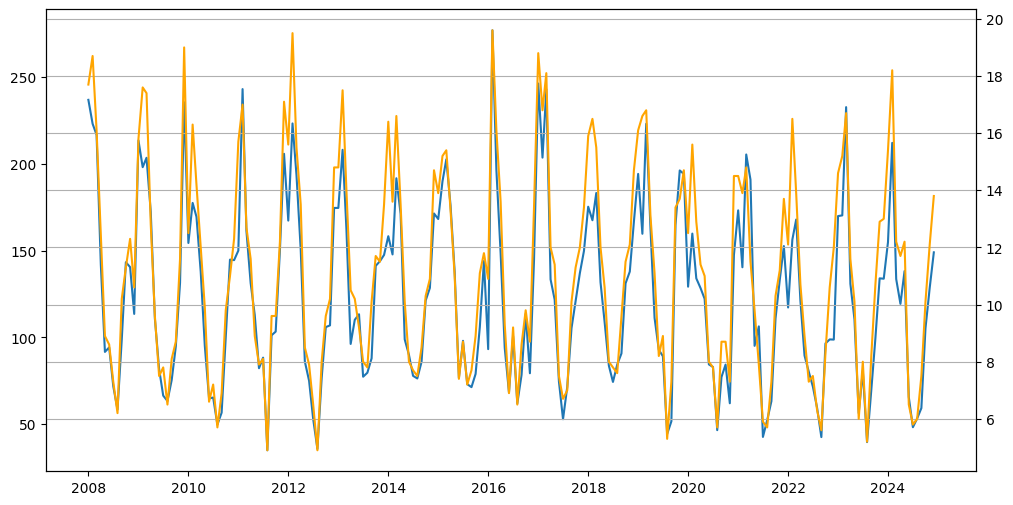

In [11]:
df_ctry_lvl['codmes_d'] = pd.to_datetime(df_ctry_lvl['codmes'], format='%Y%m')
fig, ax = plt.subplots(figsize=(12, 6))
mask_pais = df_ctry_lvl['country'] == 'Peru'
mask_meses = df_ctry_lvl['codmes_d'] >= '2008-01-01'
ax.plot(df_ctry_lvl[mask_pais&mask_meses]['codmes_d'], df_ctry_lvl[mask_pais&mask_meses]['pre'], label='Precipitación')
ax2 = ax.twinx()
ax2.plot(df_ctry_lvl[mask_pais&mask_meses]['codmes_d'], df_ctry_lvl[mask_pais&mask_meses]['wet'], label='wet days', color='orange')
plt.grid()

In [12]:
df_ctry_lvl['pre_lag'] = df_ctry_lvl.sort_values('codmes').groupby('country')['pre'].shift(12)
df_ctry_lvl['wet_lag'] = df_ctry_lvl.sort_values('codmes').groupby('country')['wet'].shift(12)

<Axes: xlabel='wet_lag', ylabel='wet'>

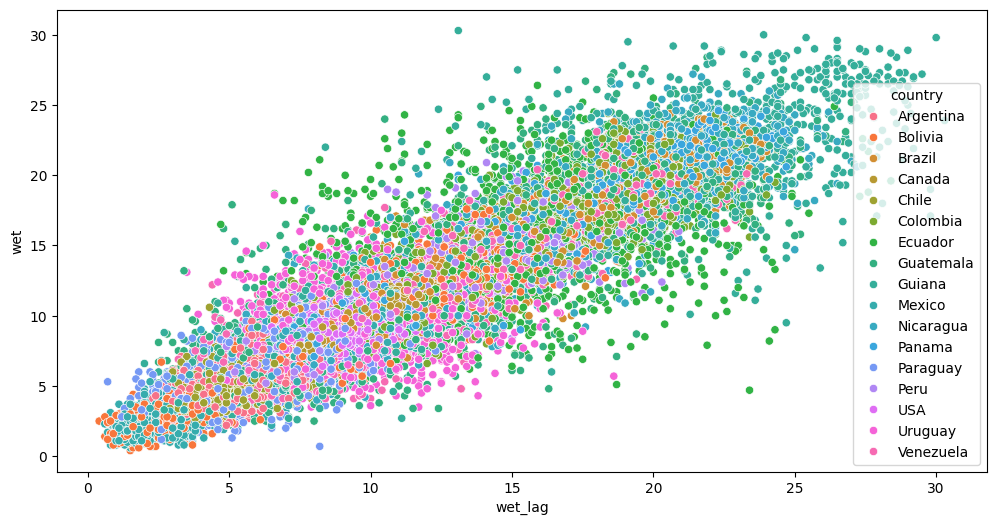

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_ctry_lvl, x='wet_lag', y='wet', ax=ax, hue='country')


<Axes: xlabel='wet_lag', ylabel='wet'>

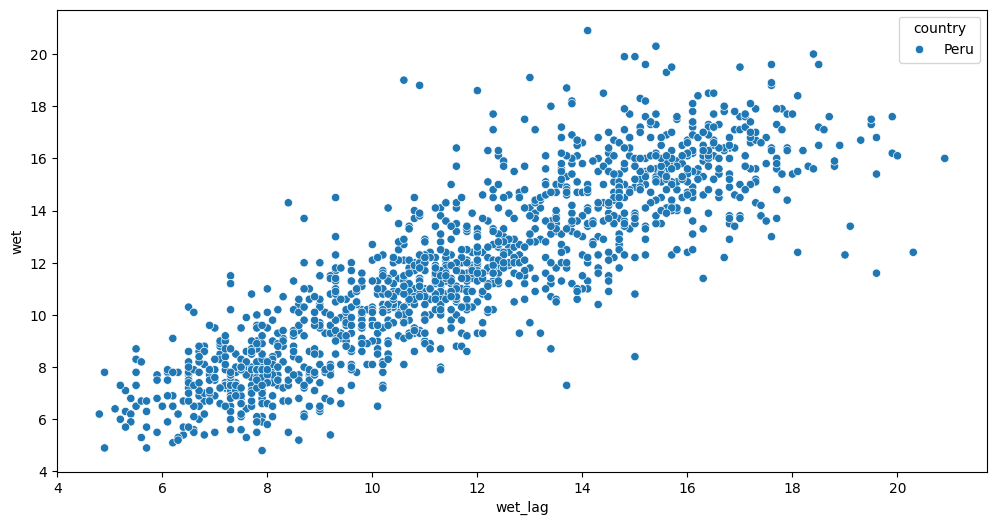

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_ctry_lvl[mask_pais], x='wet_lag', y='wet', ax=ax, hue='country')


# General Transformation

In [15]:
df_gts_reescal = df_gts.copy()
df_ctry_lvl_reescal = df_ctry_lvl.copy()

In [16]:
mi_scaler_gts = MinMaxScaler()
mi_scaler_gts.fit(df_gts_reescal[variables_gridded])

MinMaxScaler()

In [17]:
mi_scaler_ctry_lvl = MinMaxScaler()
mi_scaler_ctry_lvl.fit(df_ctry_lvl[variables_ctry_lvl])

MinMaxScaler()

In [18]:
df_gts_reescal[variables_gridded] = mi_scaler_gts.transform(df_gts_reescal[variables_gridded])
df_gts_reescal.sample()

,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,codmes,cuadrante_v1,cuadrante_v2,cuadrante_v3,mi_y,el_th_usado
925740,-79.75,-10.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197707,0.0,0,0,0,NaN


In [19]:
df_ctry_lvl_reescal[variables_ctry_lvl] = mi_scaler_ctry_lvl.transform(df_ctry_lvl_reescal[variables_ctry_lvl])
df_ctry_lvl_reescal.sample()

,codmes,country,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,codmes_d,pre_lag,wet_lag
1956,191008,Bolivia,0.248788,0.8,0.167742,0.640625,0.049498,0.788927,0.833904,0.864548,0.52459,0.070234,1910-08-01,28.2,2.4


# Tensors Creation

In [20]:
def gen_X_from_ctry_lvl(df, variables):
    dict_save_dfs = {}
    for variable in variables:
        dict_save_dfs[variable] = df.pivot_table(index='codmes', columns='country', values=variable)
        dict_rename = {col: f"{col}_{variable}" for col in dict_save_dfs[variable].columns if col != 'codmes'}
        dict_save_dfs[variable].rename(columns=dict_rename, inplace=True)
        dict_save_dfs[variable] = dict_save_dfs[variable].reset_index()
    return dict_save_dfs


In [21]:
dict_dfs_ctry_lvl_reescal = gen_X_from_ctry_lvl(df_ctry_lvl_reescal, variables_ctry_lvl)
dict_dfs_ctry_lvl_reescal.keys()

dict_keys(['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet'])

In [22]:
dict_dfs_ctry_lvl_reescal['pre'].sample(3)

country,codmes,Argentina_pre,Bolivia_pre,Brazil_pre,Canada_pre,Chile_pre,Colombia_pre,Ecuador_pre,Guatemala_pre,Guiana_pre,Mexico_pre,Nicaragua_pre,Panama_pre,Paraguay_pre,Peru_pre,USA_pre,Uruguay_pre,Venezuela_pre
460,193905,0.068245,0.089130,0.218056,0.062325,0.210163,0.427890,0.348791,0.250123,0.764348,0.056734,0.291564,0.429206,0.185989,0.175629,0.081730,0.112317,0.257359
41,190406,0.039138,0.035192,0.131886,0.083210,0.269528,0.407170,0.168722,0.508633,0.519322,0.158362,0.602039,0.437099,0.068410,0.137971,0.110179,0.121033,0.435126
1325,201106,0.045716,0.016774,0.125473,0.092419,0.187798,0.556652,0.414734,0.548758,0.402236,0.159349,0.563888,0.431508,0.081401,0.130735,0.100970,0.201447,0.420983


In [23]:
n_lon  = df_gts_reescal['lon'].unique().shape[0]
n_lat  = df_gts_reescal['lat'].unique().shape[0]
n_time = df_gts_reescal['codmes'].unique().shape[0]
print(f'Número de lon: {n_lon}')
print(f'Número de lat: {n_lat}')
print(f'Número de mes: {n_time}')

Número de lon: 28
Número de lat: 36
Número de mes: 1488


In [24]:
df_gts_reescal

,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,codmes,cuadrante_v1,cuadrante_v2,cuadrante_v3,mi_y,el_th_usado
0,-81.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
1,-81.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
2,-80.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
3,-80.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
4,-79.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499899,-70.25,-0.25,0.867380,0.242553,NaN,0.358491,0.115866,0.910891,0.899696,0.832192,0.899390,0.800000,202412,1.0,1,1,1,25.0
1499900,-69.75,-0.25,0.913369,0.238298,NaN,0.301887,0.126326,0.891089,0.875380,0.801370,0.896341,0.833333,202412,1.0,1,1,1,25.0
1499901,-69.25,-0.25,0.964706,0.238298,NaN,0.283019,0.138639,0.888614,0.872340,0.797945,0.902439,0.800000,202412,1.0,1,1,1,25.0
1499902,-68.75,-0.25,0.977540,0.238298,NaN,0.264151,0.150450,0.891089,0.875380,0.801370,0.917683,0.766667,202412,1.0,1,1,0,NaN


In [25]:
df_gts_reescal.sort_values(by = ['codmes', 'lat', 'lon'])
# Este es el orden en que se generó el DF

,lon,lat,cld,dtr,frs,pet,pre,tmn,tmp,tmx,vap,wet,codmes,cuadrante_v1,cuadrante_v2,cuadrante_v3,mi_y,el_th_usado
0,-81.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
1,-81.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
2,-80.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
3,-80.25,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
4,-79.75,-17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190101,0.0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499899,-70.25,-0.25,0.867380,0.242553,NaN,0.358491,0.115866,0.910891,0.899696,0.832192,0.899390,0.800000,202412,1.0,1,1,1,25.0
1499900,-69.75,-0.25,0.913369,0.238298,NaN,0.301887,0.126326,0.891089,0.875380,0.801370,0.896341,0.833333,202412,1.0,1,1,1,25.0
1499901,-69.25,-0.25,0.964706,0.238298,NaN,0.283019,0.138639,0.888614,0.872340,0.797945,0.902439,0.800000,202412,1.0,1,1,1,25.0
1499902,-68.75,-0.25,0.977540,0.238298,NaN,0.264151,0.150450,0.891089,0.875380,0.801370,0.917683,0.766667,202412,1.0,1,1,0,NaN


In [26]:
a = df_gts_reescal.sort_values(by = ['codmes', 'lat', 'lon'])['lat'].values.reshape((n_time, n_lat, n_lon))

In [27]:
a.shape

(1488, 36, 28)

In [28]:
def transform_data_for_lstm(df, col_to_extr, add_miss_layer = True, fillna_with = 0):
    n_lon  = df['lon'].unique().shape[0]
    n_lat  = df['lat'].unique().shape[0]
    n_time = df['codmes'].unique().shape[0]

    df_sorteado = df.sort_values(by = ['codmes', 'lat', 'lon'])
    if add_miss_layer:
        miss_layer = df_sorteado[col_to_extr].isna().values.reshape((n_time, n_lat, n_lon))
        la_data = df_sorteado[col_to_extr].fillna(fillna_with).values.reshape((n_time, n_lat, n_lon))
        return la_data, miss_layer
    la_data = df_sorteado[col_to_extr].fillna(fillna_with).values.reshape((n_time, n_lat, n_lon))
    return la_data

In [29]:
def create_Y_X(df, cols_for_X_gts, add_miss_layer = True, n_years_for_X = 8, n_months_ahead_target = 12, target_name = 'mi_y', include_ctry_lvl = False, **kwargs):
    start_time = datetime.now()
    # El output esperado de Y es (n_months_ahead_target, lat, lon)
    desde_codmes_X = df['codmes'].min()
    hasta_codmes_X = add_months_to_date(desde_codmes_X, n_years_for_X * 12 - 1)
    primer_codmes_X_ctry_lvl = hasta_codmes_X
    desde_codmes_Y = add_months_to_date(hasta_codmes_X, 1)
    hasta_codmes_Y = add_months_to_date(desde_codmes_Y, n_months_ahead_target-1)
    max_codmes = df['codmes'].max()
    
    # Print the Rangos iniciales
    print(f'Rangos iniciales:')
    print(f'X: desde {desde_codmes_X} hasta {hasta_codmes_X}')
    print(f'Y: desde {desde_codmes_Y} hasta {hasta_codmes_Y}')

    en_rango_df = True
    n_iter = 0
    while en_rango_df:
        # Get X gridded time series data set into tensor format
        df_for_x = df[df['codmes'].between(desde_codmes_X, hasta_codmes_X)]
        for i_esima_var in cols_for_X_gts:
            # Transform the data for LSTM 
            result_trans_lstm_x = transform_data_for_lstm(df_for_x, col_to_extr = i_esima_var, add_miss_layer = add_miss_layer)
            if add_miss_layer:
                la_data_x, miss_layer_x = result_trans_lstm_x
                # We ensure the first dimension is (1, n_time, n_lat, n_lon) so we can use concat later.
                la_data_x = np.expand_dims(la_data_x, 0)
                miss_layer_x = np.expand_dims(miss_layer_x, 0)
            else:
                la_data_x = result_trans_lstm_x
                la_data_x = np.expand_dims(la_data_x, 0)
            # If this is the first variable, we initialize the arrays we will use to store the data from all variables.
            if i_esima_var == cols_for_X_gts[0]:
                la_data_x_all = la_data_x
                if add_miss_layer:
                    miss_layer_x_all = miss_layer_x
            # If not, we concatenate the new data with the existing data.
            else:
                la_data_x_all = np.concat((la_data_x_all, la_data_x))
                if add_miss_layer:
                    miss_layer_x_all = np.concat((miss_layer_x_all, miss_layer_x))
            #This generates a 4D array with shape (n_vars, n_time, n_lat, n_lon)
        # Get Y
        df_for_y = df[df['codmes'].between(desde_codmes_Y, hasta_codmes_Y)]
        el_y = transform_data_for_lstm(df_for_y, col_to_extr = target_name, add_miss_layer = False)

        # Transforms results from iteraation into a 5D array with shape (1, n_vars, n_time, n_lat, n_lon)
        la_data_x_all = np.expand_dims(la_data_x_all, 0)
        # Transforms Y into a 4D array with shape (1, n_time, n_lat, n_lon)
        el_y          = np.expand_dims(el_y, 0)
        if add_miss_layer:
            miss_layer_x_all = np.expand_dims(miss_layer_x_all, 0)

        if n_iter == 0:
            la_data_x_all_times = la_data_x_all
            el_y_all_times = el_y
            if add_miss_layer:
                miss_layer_x_all_times = miss_layer_x_all
        else:
            la_data_x_all_times = np.concat((la_data_x_all_times, la_data_x_all))
            el_y_all_times = np.concat((el_y_all_times, el_y))
            if add_miss_layer:
                miss_layer_x_all_times = np.concat((miss_layer_x_all_times, miss_layer_x_all))

        # Movemos los meses para generar nuevos registros en X y Y
        desde_codmes_X = add_months_to_date(desde_codmes_X, 1)
        hasta_codmes_X = add_months_to_date(hasta_codmes_X, 1)
        desde_codmes_Y = add_months_to_date(desde_codmes_Y, 1)
        hasta_codmes_Y = add_months_to_date(hasta_codmes_Y, 1)
        # Verificamos si los codmes están dentro del rango del DF (se debe verificar que sea en base a Y, no a X)
        if hasta_codmes_Y>max_codmes:
            ultimo_codmes_X_ctry_lvl = add_months_to_date(hasta_codmes_X, -1)
            en_rango_df = False
        n_iter += 1

    # Generación de los X de ctry lvl
    if include_ctry_lvl:
        # Check if dict_dfs_ctry_lvl_reescal is provided in kwargs
        if 'dict_dfs_ctry_lvl_reescal' not in kwargs.keys():
            raise ValueError("If include_ctry_lvl is True, dict_dfs_ctry_lvl_reescal must be provided in kwargs.")
        dict_dfs_ctry_lvl_reescal = kwargs['dict_dfs_ctry_lvl_reescal']
        lista_ctry_lvl_dataframe = list(dict_dfs_ctry_lvl_reescal.keys())
        for i_esima_var_crty_lvl in lista_ctry_lvl_dataframe:
            ctry_lvl_tensor = dict_dfs_ctry_lvl_reescal[i_esima_var_crty_lvl]
            ctry_lvl_tensor = ctry_lvl_tensor.sort_values(by = ['codmes'])
            ctry_lvl_tensor = ctry_lvl_tensor[ctry_lvl_tensor['codmes'].between(primer_codmes_X_ctry_lvl, ultimo_codmes_X_ctry_lvl)]

            if i_esima_var_crty_lvl == lista_ctry_lvl_dataframe[0]:
                ctry_lvl_tensor_all = ctry_lvl_tensor.values
            else:
                ctry_lvl_tensor_all = np.hstack((ctry_lvl_tensor_all, ctry_lvl_tensor))

    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print(f'{bcolors.BOLD}{bcolors.FAIL}Elapsed time:{bcolors.ENDC}{bcolors.ENDC} {bcolors.MORADO}{elapsed_time}{bcolors.ENDC}')
    return la_data_x_all_times, el_y_all_times, miss_layer_x_all_times if add_miss_layer else None, ctry_lvl_tensor_all if include_ctry_lvl else None


In [30]:
add_miss_layer        = True     # Si se quiere agregar una capa de missing values (True) o no (False)
include_ctry_lvl      = True     # Si se quiere incluir los datos de country-level (True) o no (False)
n_years_for_X         = 8        # Número de lags que se usarán para generar X, en años
n_months_ahead_target = 12       # Número de meses que se quiere predecir hacia adelante
target_name           = 'mi_y'   # Nombre de la variable objetivo

lim_train             = 200801   # Límite del dataset de train
# Para no desperdiciar datos simplemente partiendo en 2 (por un solo th) generamos 2 th, uno para entrenamiento y otro para out-of-time (oot), pero teniendo en cuenta que no debemos juntar los meses de Y que el modelo ya vio con los de OOT
lim_oot               = add_months_to_date(lim_train, - n_years_for_X * 12)

df_train = df_gts_reescal[df_gts_reescal['codmes'] < lim_train]
df_oot = df_gts_reescal[df_gts_reescal['codmes'] >= lim_oot]

In [31]:
X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = create_Y_X(
                                                            df                        = df_train,
                                                            cols_for_X_gts            = variables_gridded,
                                                            add_miss_layer            = add_miss_layer,
                                                            n_years_for_X             = n_years_for_X,
                                                            n_months_ahead_target     = n_months_ahead_target,
                                                            target_name               = target_name, 
                                                            include_ctry_lvl          = include_ctry_lvl,
                                                            dict_dfs_ctry_lvl_reescal = dict_dfs_ctry_lvl_reescal
                                                            )

Rangos iniciales:
X: desde 190101 hasta 190812
Y: desde 190901 hasta 190912
Elapsed time: 1:52:57.125572


In [32]:
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = create_Y_X(
                                                            df                        = df_oot,
                                                            cols_for_X_gts            = variables_gridded,
                                                            add_miss_layer            = add_miss_layer,
                                                            n_years_for_X             = n_years_for_X,
                                                            n_months_ahead_target     = n_months_ahead_target,
                                                            target_name               = target_name, 
                                                            include_ctry_lvl          = include_ctry_lvl,
                                                            dict_dfs_ctry_lvl_reescal = dict_dfs_ctry_lvl_reescal
                                                            )

Rangos iniciales:
X: desde 200001 hasta 200712
Y: desde 200801 hasta 200812
Elapsed time: 0:00:54.825862


In [ ]:
joblib.dump((X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot), el_path_main / '2. Datos/Processed data/OOT_data.pkl')
joblib.dump((X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train), el_path_main / '2. Datos/Processed data/TRAIN_data.pkl')

In [31]:
X_gts_train, Y_train, X_gts_miss_train, X_ctry_lvl_train = joblib.load(el_path_main / '2. Datos/Processed data/TRAIN_data.pkl')
X_gts_oot, Y_oot, X_gts_miss_oot, X_ctry_lvl_oot = joblib.load(el_path_main / '2. Datos/Processed data/OOT_data.pkl')

In [32]:
X_gts_oot.shape, Y_oot.shape, X_gts_miss_oot.shape, X_ctry_lvl_oot.shape

((193, 10, 96, 36, 28), (193, 12, 36, 28), (193, 10, 96, 36, 28), (193, 180))

In [33]:
X_gts_train.shape, Y_train.shape, X_gts_miss_train.shape, X_ctry_lvl_train.shape

((1177, 10, 96, 36, 28),
 (1177, 12, 36, 28),
 (1177, 10, 96, 36, 28),
 (1177, 180))

Los tensores tienen las siguientes formas
$$
Size(X_{gts\_train}) = (n\_samples, n\_variables, n\_periods, n\_lat, n\_lon)\\
Size(Y_{train}) = (n\_samples, n\_periods\_to\_forecast, n\_lat, n\_lon)\\
Size(X_{gts\_miss\_train}) = (n\_samples, n\_variables, n\_periods, n\_lat, n\_lon)\\
Size(X_{ctry\_lvl\_train}) = (n\_samples, k)
$$
donde $k$ es el número de variables generdos de forma tabular:
* cld de país $i$
* tmp de país $i$
* ...

In [ ]:
# Puedo usar channels de conv lstm para indicar con una capa los valores y con otra los que son missing
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D